In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [5]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

start_time   end_time labels indv  indvi subject_importance  \
0    9.842790  10.105938     ah  ORA      0    Primary subject   
1   72.031245  72.346332     ah  ORA      0    Primary subject   
2   74.130176  74.376012     bz  ORA      0    Primary subject   

                          key  \
0  2014-05-29_10-10-00-000000   
1  2014-05-29_10-10-00-000000   
2  2014-05-29_10-10-00-000000   

                                               audio   rate  \
0  [-0.19927763130383222, -0.2129138251615996, -0...  44100   
1  [-0.12207342570633199, -0.09996911527363203, -...  44100   
2  [-0.0889848557398444, -0.06770700742932487, -0...  44100   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0...

In [10]:
len(syllable_df)

67032

In [11]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [12]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [14]:
import hdbscan

In [15]:
from avgn.visualization.projections import draw_projection_transitions

In [16]:
syllable_df = syllable_df.sort_values(by=["key", "start_time"])
print(len(syllable_df))
specs = [norm(i) for i in syllable_df.spectrogram.values]

# sequencing
syllable_df["syllables_sequence_id"] = None
syllable_df["syllables_sequence_pos"] = None
for ki, key in enumerate(syllable_df.key.unique()):
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_id"] = ki
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_pos"] = np.arange(
        np.sum(syllable_df.key == key)
    )

67032


In [17]:
# umap
specs_flattened = flatten_spectrograms(specs)
cuml_umap = cumlUMAP(min_dist=0.5)
z = list(cuml_umap.fit_transform(specs_flattened))
syllable_df["umap"] = z

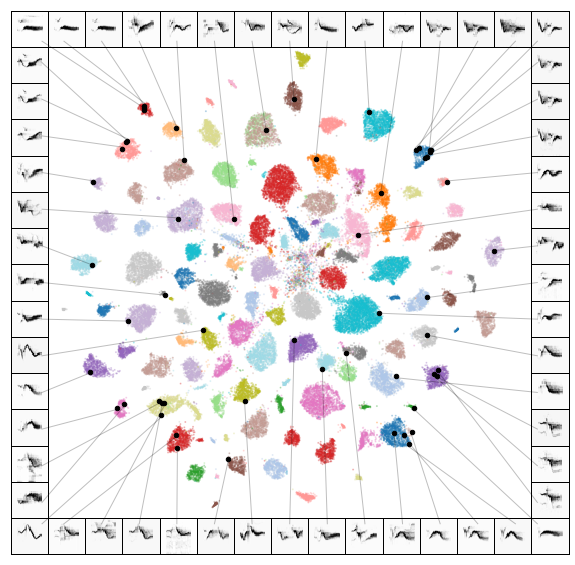

In [18]:
# plot
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(syllable_df.labels.values),
        'alpha':0.25,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    #ax= ax[0,indvi]
);

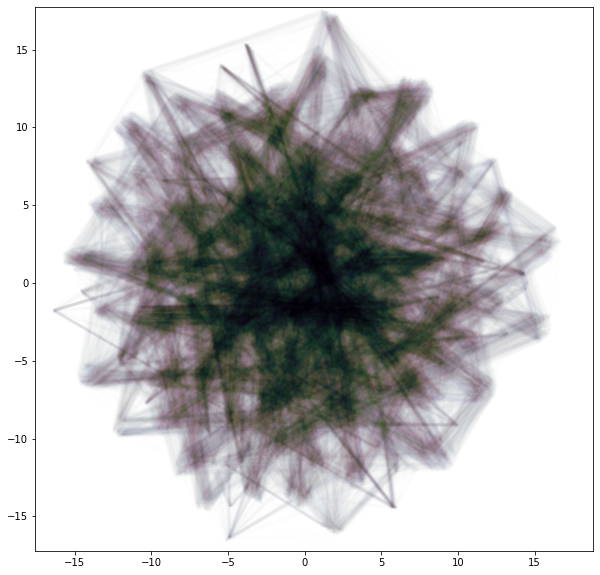

In [19]:
draw_projection_transitions(
    projections=np.array(list(syllable_df['umap'].values)),
    sequence_ids=syllable_df["syllables_sequence_id"],
    sequence_pos=syllable_df["syllables_sequence_pos"],
    #ax=ax[1,indvi],
    alpha = 0.0025
)

In [20]:
### PCA

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
z_pca = pca.fit_transform(specs_flattened)

### label

In [22]:
from sklearn.cluster import MiniBatchKMeans

In [23]:
### HDBSCAN on PCA
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(z_pca);
syllable_df['hdbscan_labels_PCA'] = clusterer.labels_

In [24]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(z);
syllable_df['hdbscan_labels'] = clusterer.labels_

In [25]:
# HDBSCAN 
specs = [norm(i) for i in syllable_df.spectrogram.values]
specs_flattened = flatten_spectrograms(specs)

In [26]:
# kmeans
# get number of possible states
n_states = len(syllable_df.labels.unique())

kmeans = MiniBatchKMeans(n_clusters = n_states).fit(z)
syllable_df['kmeans_labels'] = kmeans.labels_

In [27]:
# kmeans data
kmeans = MiniBatchKMeans(n_clusters = n_states).fit(specs_flattened)
syllable_df['kmeans__pix_labels'] = kmeans.labels_

### save dataframes for paper

In [29]:
ensure_dir(DATA_DIR / "paper_data" / "clustering_umap" / "cassins")

In [32]:
syllable_df[:3]

start_time  end_time labels                indv  indvi subject_importance  \
0    0.409923  0.699019     aa  CAVIFTANN-Spingr10      0    Primary subject   
1    3.198697  3.658817     ab  CAVIFTANN-Spingr10      0    Primary subject   
2    6.484191  7.048617     ac  CAVIFTANN-Spingr10      0    Primary subject   

                          key  \
0  2010-04-23_09-50-00-000000   
1  2010-04-23_09-50-00-000000   
2  2010-04-23_09-50-00-000000   

                                               audio   rate  \
0  [-0.031764211075726356, -0.028940513344805425,...  44100   
1  [-0.08963779017337521, -0.05187374316311154, 0...  44100   
2  [-0.1613153870893983, -0.07493769563533478, 0....  44100   

                                         spectrogram  syllables_sequence_id  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                      0   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                      0   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                      0   

   syllables_sequence_pos                                         umap  \
0                       0     [3.9686520099639893, 1.2450162172317505]   
1                       1  [-0.34736204147338867, -0.2273869812488556]   
2                       2    [1.5540518760681152, -5.5670671463012695]   

   hdbscan_labels_PCA  hdbscan_labels  kmeans_labels  kmeans__pix_labels  
0                  52             107            149                 150  
1                  32              82             72                  77  
2                   1              66             59                 159

In [31]:
syllable_df.to_pickle(DATA_DIR / "paper_data" / "clustering_umap" / "cassins" / "all.pickle")

### plot

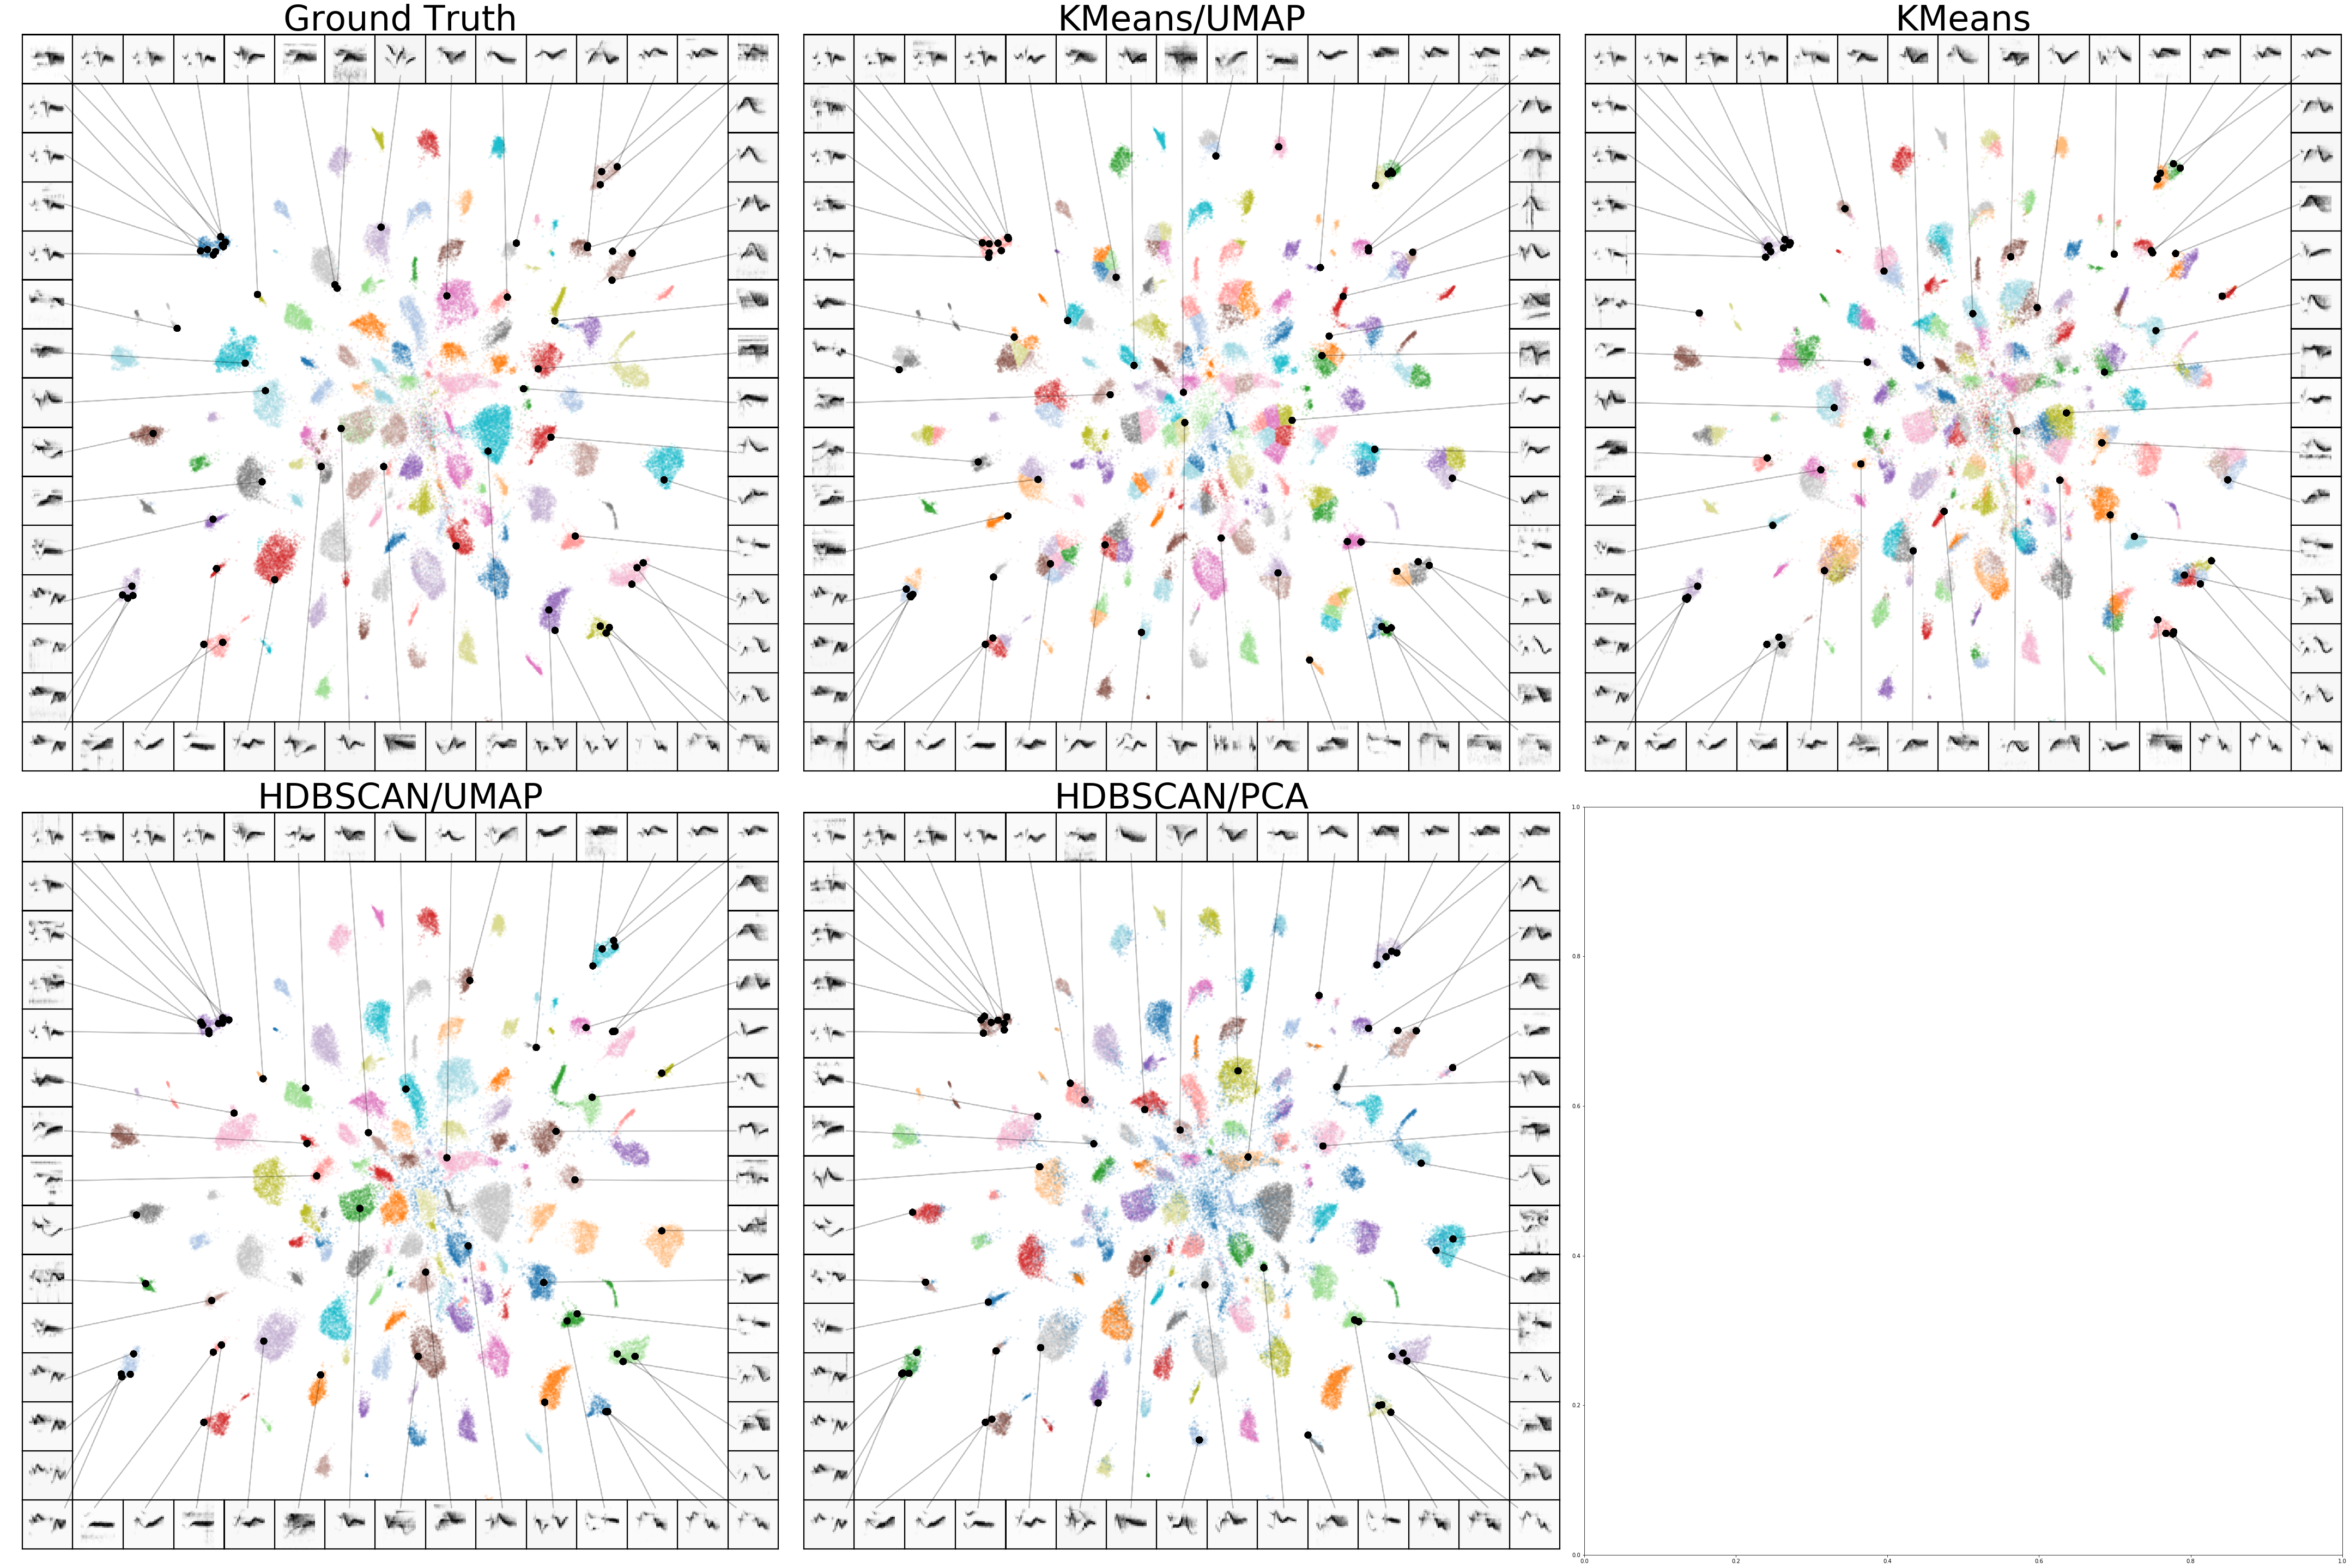

In [28]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(60, 40))
"""draw_projection_transitions(
    projections=np.array(list(syllable_df["umap"].values)),
    sequence_ids=syllable_df["syllables_sequence_id"],
    sequence_pos=syllable_df["syllables_sequence_pos"],
    ax=axs[0],
)"""

for i, (lablab, lab) in enumerate(
    tqdm([
        ["Ground Truth", "labels"],
        ['KMeans/UMAP',"kmeans_labels"],
        ["KMeans" , "kmeans__pix_labels"],
        ["HDBSCAN/UMAP", "hdbscan_labels"],
        ["HDBSCAN/PCA", "hdbscan_labels_PCA"],
    ]
)):
    ax = axs.flatten()[i]
    scatter_spec(
        np.array(list(syllable_df["umap"].values)),
        specs = syllable_df.spectrogram.values,
        column_size=15,
        # x_range = [-5.5,7],
        # y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs={
            "labels": list(syllable_df[lab].values),
            "alpha": 0.1,
            "s": 1,
            "show_legend": False,
        },
        matshow_kwargs={"cmap": plt.cm.Greys},
        line_kwargs={"lw": 1, "ls": "solid", "alpha": 0.25},
        draw_lines=True,
        ax=ax,
    )
    ax.set_title(lablab,fontsize=64)
    ax.axis('off')

#save_fig(FIGURE_DIR / 'clustering_example_wPCA', dpi=300, save_jpg=True)
plt.tight_layout()
plt.show()

### human vs algorithmic labelling similarity

In [29]:
import sklearn.metrics

In [30]:
performance_df = pd.DataFrame(columns = ['indv', 'cluster', 'homogeneity', 'completeness', 'V-Measure', 'Adj. MI'])
for cluster in ['hdbscan_labels', 'kmeans__pix_labels', 'kmeans_labels', 'hdbscan_labels_PCA']:
    homogenaity, completeness, v_measure = sklearn.metrics.homogeneity_completeness_v_measure(
        list(syllable_df.labels), list(syllable_df[cluster].values)
    )
    ami = sklearn.metrics.adjusted_mutual_info_score(
        list(syllable_df.labels), list(syllable_df[cluster].values)
    )
    performance_df.loc[len(performance_df)] = ['All', cluster, homogenaity, completeness, v_measure, ami]

In [31]:
performance_df[:4]

indv             cluster  homogeneity  completeness  V-Measure   Adj. MI
0  All      hdbscan_labels     0.936336      0.939551   0.937941  0.936234
1  All  kmeans__pix_labels     0.894226      0.807951   0.848902  0.843197
2  All       kmeans_labels     0.927597      0.828854   0.875450  0.870736
3  All  hdbscan_labels_PCA     0.849434      0.906232   0.876915  0.873670

In [32]:
cats = ["homogeneity", "completeness", "V-Measure", "Adj. MI"]
results_latex_df = pd.DataFrame(
    columns=["Homogeneity", "Completeness", "V-Measure", "Adjusted MI"]
)

labs = [['hdbscan_labels', 'HDBSCAN/UMAP'], ['kmeans__pix_labels', 'KMeans'], ['kmeans_labels', 'KMeans/UMAP'], ['hdbscan_labels_PCA', 'HDBSCAN/PCA']]

for lab, name in labs:
    results_latex_df.loc[name] = [
        str(
            round(np.mean(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        for i in cats
    ]
results_latex_df = pd.concat([results_latex_df], keys=[''], names=['Cassin\'s vireo'])
results_latex_df

Homogeneity Completeness V-Measure Adjusted MI
Cassin's vireo                                                            
               HDBSCAN/UMAP       0.936         0.94     0.938       0.936
               KMeans             0.894        0.808     0.849       0.843
               KMeans/UMAP        0.928        0.829     0.875       0.871
               HDBSCAN/PCA        0.849        0.906     0.877       0.874

In [33]:
results_string = results_latex_df.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
.replace('±', '$\pm$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)


\begin{tabular}{llllll}
\toprule
               &             & Homogeneity & Completeness & V-Measure & Adjusted MI \\
\midrule
\textbf{Cassin's vireo} & {} &             &              &           &             \\
\midrule
               & \textbf{HDBSCAN/UMAP} &       0.936 &         0.94 &     0.938 &       0.936 \\
               & \textbf{KMeans} &       0.894 &        0.808 &     0.849 &       0.843 \\
               & \textbf{KMeans/UMAP} &       0.928 &        0.829 &     0.875 &       0.871 \\
               & \textbf{HDBSCAN/PCA} &       0.849 &        0.906 &     0.877 &       0.874 \\
\bottomrule
\end{tabular}



In [34]:
import seaborn as sns
sns.set_context("paper", font_scale=2)

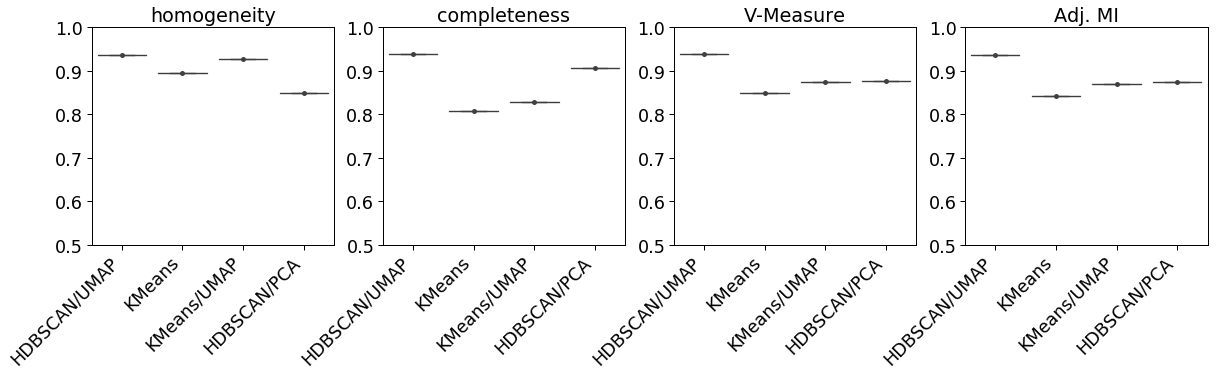

In [35]:
fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

for ci, column in enumerate(["homogeneity", "completeness", "V-Measure", "Adj. MI"]):
    sns.boxplot(x="cluster", y=column, data =performance_df, ax = axs[ci])
    sns.swarmplot(x="cluster", y=column, data =performance_df, ax = axs[ci], color=".25")
    axs[ci].set_ylim([0.5,1])
    axs[ci].set_xticklabels(['HDBSCAN/UMAP', 'KMeans', 'KMeans/UMAP', 'HDBSCAN/PCA'], rotation=45, ha='right')
    axs[ci].set_xlabel('')
    axs[ci].set_ylabel('')
    axs[ci].set_title(column)



[autoreload of networkx.classes.graph failed: Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/networkx/classes/graph.py", line 28, in <module>


labels


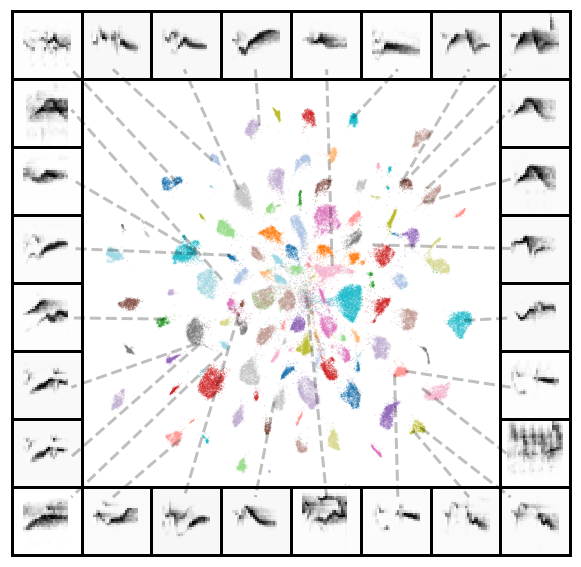

kmeans_labels


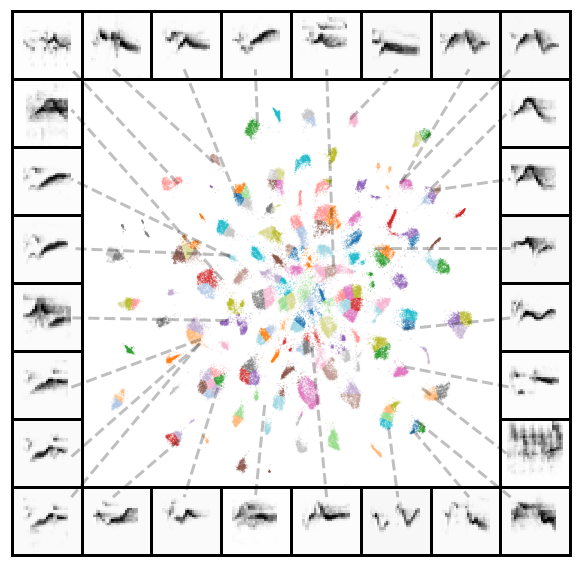

kmeans__pix_labels


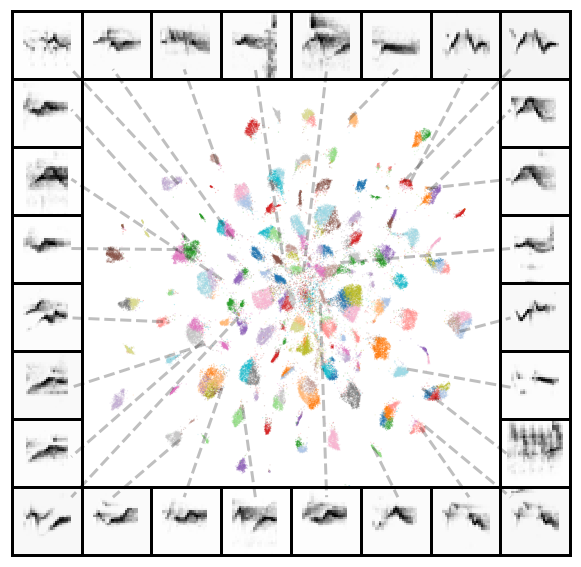

hdbscan_labels


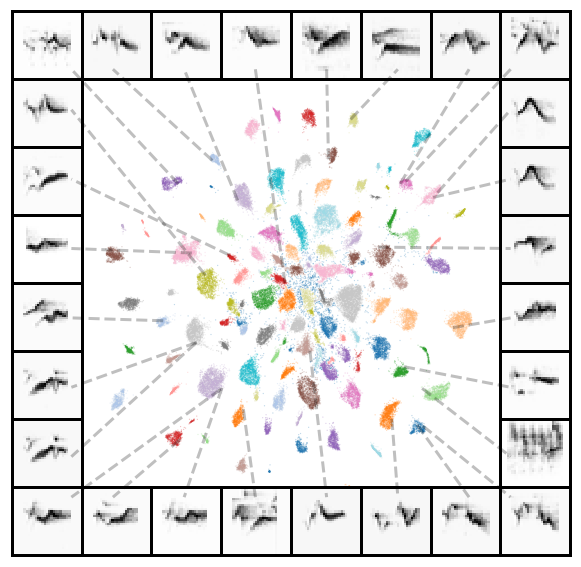

hdbscan_labels_PCA


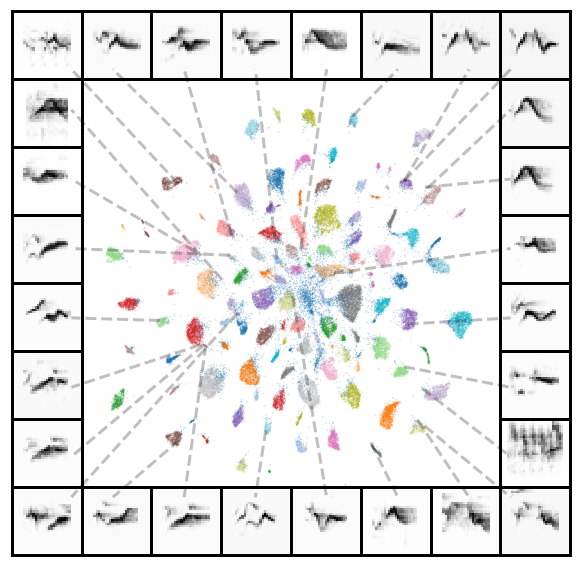

In [39]:
for i, (lablab, lab) in enumerate(
    tqdm([
        ["Ground Truth", "labels"],
        ['KMeans/UMAP',"kmeans_labels"],
        ["KMeans" , "kmeans__pix_labels"],
        ["HDBSCAN/UMAP", "hdbscan_labels"],
        ["HDBSCAN/PCA", "hdbscan_labels_PCA"],
    ]
)):
    print(lab)
    nex = -1
    scatter_spec(
        np.array(list(syllable_df["umap"].values)),
        specs = syllable_df.spectrogram.values,
        column_size=8,
        #x_range = [-4.5,4],
        #y_range = [-4.5,5.5],
        pal_color="hls",
        color_points=False,
        enlarge_points=0,
        figsize=(10, 10),
        range_pad = 0.1,
        scatter_kwargs = {
            'labels': list(syllable_df[lab].values),
            'alpha':0.25,
            's': 0.25,
            'show_legend': False,
            'color_palette':'tab20'
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':3,
            'ls':"dashed",
            'alpha':0.25,
        },
        draw_lines=True,
        n_subset= 1000,
        border_line_width = 3,
    );
    
    
    save_fig(FIGURE_DIR / 'cassins_cluster' / ('clustering_example_cassin_' + lab), dpi=300, save_jpg=True, save_png=True)
    plt.show()
